In [2]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage


In [3]:
#Load Dataset
df = pd.read_csv("../data/heart_disease.csv")
df["ca"].fillna(df["ca"].mean(),inplace=True)
df['thal'].fillna(df["thal"].mean(),inplace=True)
X=df.drop("num",axis=1)
y=df["num"]

C:\Users\AIO\AppData\Local\Temp\ipykernel_6888\1224606734.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ca"].fillna(df["ca"].mean(),inplace=True)
C:\Users\AIO\AppData\Local\Temp\ipykernel_6888\1224606734.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [4]:

# Scale features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data shape:", X_scaled.shape)


Scaled data shape: (303, 13)


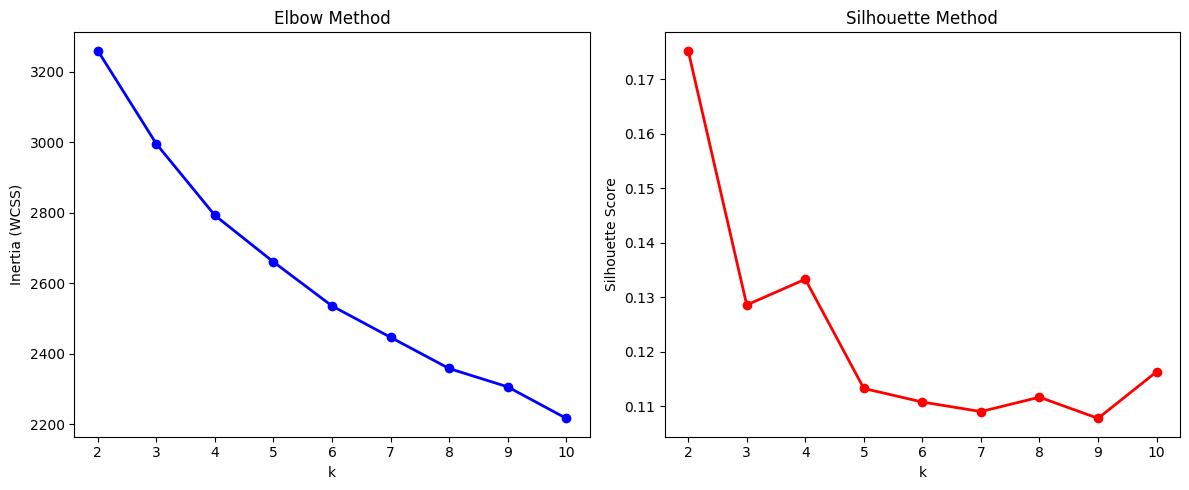

In [5]:
#  Determine optimal K using Elbow and Silhouette
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertia, 'bo-', linewidth=2)
plt.xlabel("k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(list(K_range), silhouette_scores, 'ro-', linewidth=2)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.tight_layout()
plt.show()


In [6]:
#Run KMeans with optimal k (choose from previous step)
optimal_k = 3  # <-- change this based on elbow/silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df_clusters = df.copy()
df_clusters["kmeans_cluster"] = kmeans_labels

print("KMeans cluster counts:\n", df_clusters["kmeans_cluster"].value_counts())


KMeans cluster counts:
 kmeans_cluster
2    119
1    104
0     80
Name: count, dtype: int64


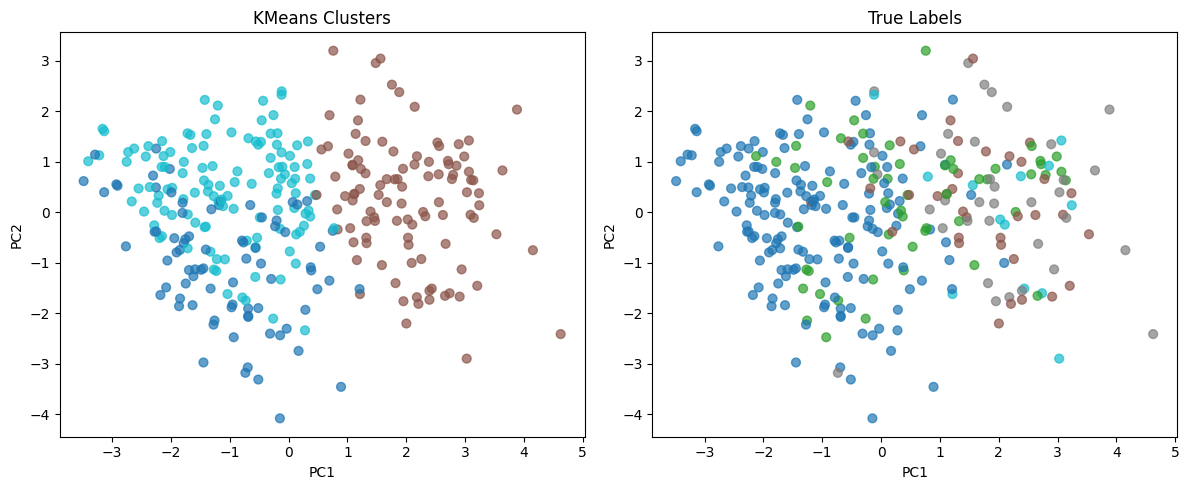

In [7]:
# Visualize KMeans clusters vs true labels using PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))

# By KMeans clusters
plt.subplot(1,2,1)
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=kmeans_labels, cmap='tab10', s=40, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters")

# By true labels
plt.subplot(1,2,2)
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='tab10', s=40, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("True Labels")
plt.tight_layout()
plt.show()


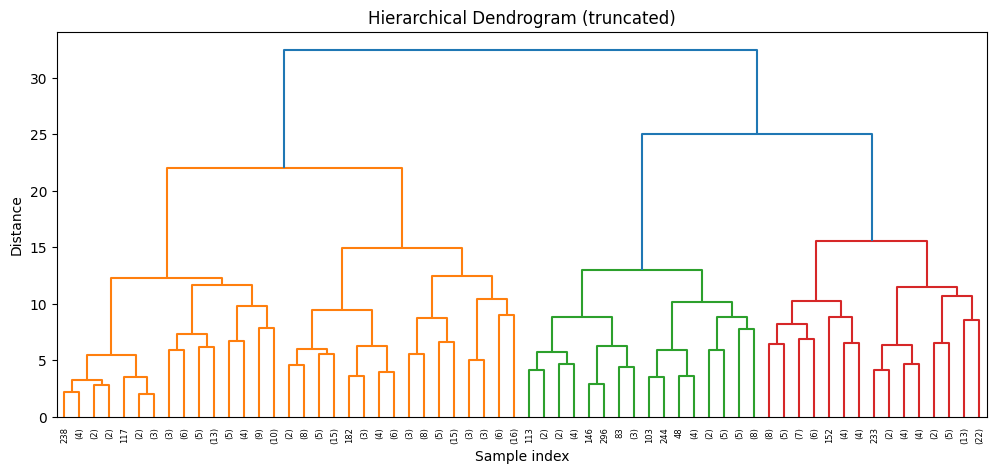

HC cluster counts:
 0    173
1     88
2     42
Name: count, dtype: int64


In [9]:
#  Hierarchical Clustering
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12,5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Dendrogram (truncated)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Cut dendrogram at chosen k
hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

df_clusters["hc_cluster"] = hc_labels
print("HC cluster counts:\n", pd.Series(hc_labels).value_counts())


KMeans - ARI: 0.1963690911339094 NMI: 0.27516774822710965
Hierarchical - ARI: 0.2727801858761655 NMI: 0.18802459590352646

Cross-tab KMeans:
 KMeansCluster   0   1   2
True                     
0              72  10  82
1               7  20  28
2               0  31   5
3               1  31   3
4               0  12   1


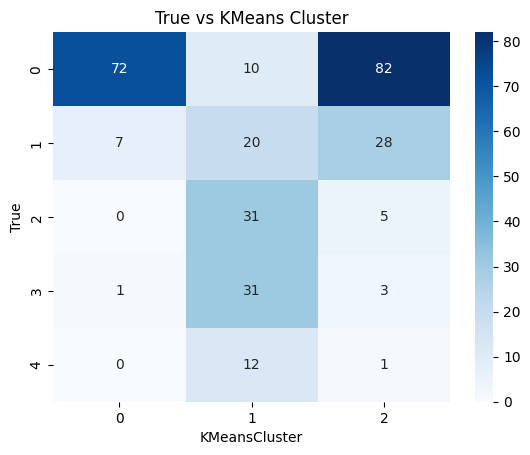


Cross-tab HC:
 HCCluster    0   1   2
True                  
0          129  13  22
1           33  18   4
2            6  22   8
3            3  25   7
4            2  10   1


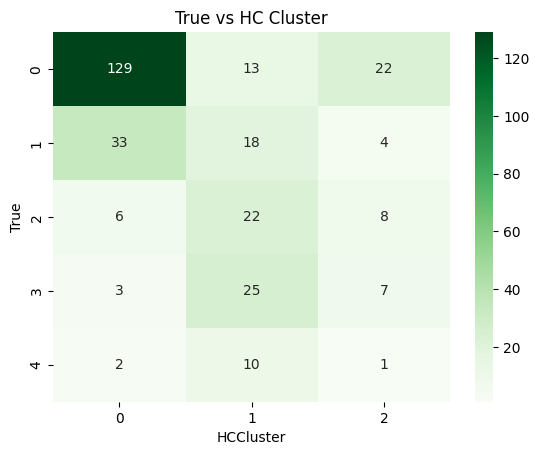

In [10]:
# Compare clustering with true labels (num)
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y, kmeans_labels)
ari_hc = adjusted_rand_score(y, hc_labels)
nmi_hc = normalized_mutual_info_score(y, hc_labels)

print("KMeans - ARI:", ari_kmeans, "NMI:", nmi_kmeans)
print("Hierarchical - ARI:", ari_hc, "NMI:", nmi_hc)

# Cross-tab for KMeans
ct_k = pd.crosstab(y, kmeans_labels, rownames=['True'], colnames=['KMeansCluster'])
print("\nCross-tab KMeans:\n", ct_k)
sns.heatmap(ct_k, annot=True, fmt='d', cmap='Blues')
plt.title("True vs KMeans Cluster")
plt.show()

# Cross-tab for Hierarchical
ct_h = pd.crosstab(y, hc_labels, rownames=['True'], colnames=['HCCluster'])
print("\nCross-tab HC:\n", ct_h)
sns.heatmap(ct_h, annot=True, fmt='d', cmap='Greens')
plt.title("True vs HC Cluster")
plt.show()
